# Income Range, US Census 1994

Data from: https://archive.ics.uci.edu/ml/datasets/Adult

Task is to classify income into two groups: less than or equal to 50k/year, or more than 50k/year

In [1]:
%matplotlib inline

import collections
import os
import os.path

import pandas as pd
import numpy as np
import sklearn
from ggplot import *
import matplotlib.pyplot as plt

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
def plot_interactive_tree(model, feature_names, class_names=None):
    from IPython.display import Image  
    from sklearn import tree
    import pydotplus 
    dot_data = tree.export_graphviz(model, out_file=None, 
                         feature_names=feature_names,
                         class_names=class_names,
                         filled=True, rounded=True,  
                         special_characters=True)  

    graph = pydotplus.graph_from_dot_data(dot_data.decode('ascii').encode('utf8'))  

    return Image(graph.create_png()) 


def plot_kfold_roc_auc(classifier, X, y, k=5):
    from scipy import interp
    from sklearn.metrics import roc_curve, auc
    from sklearn.cross_validation import StratifiedKFold

    cv = StratifiedKFold(y, n_folds=k)
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []

    for i, (train, test) in enumerate(cv):
        probas_ = classifier.fit(X.iloc[train], y.iloc[train]).predict_proba(X.iloc[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y.iloc[test], probas_[:, 1])
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

    mean_tpr /= len(cv)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)

    plt.plot(mean_fpr, mean_tpr, 'k--',
             label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)
    
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
    
def plot_roc_and_metrics(classifier, X, y):
    from sklearn import metrics

    preds = classifier.predict_proba(X)[:,1]
    fpr, tpr, _ = metrics.roc_curve(y, preds)

    print 'Testing AUC: {:.3f}'.format(metrics.roc_auc_score(y, preds))

    print metrics.classification_report(y, [round(x) for x in preds])

    df = pd.DataFrame(dict(fpr=fpr, tpr=tpr))
    print ggplot(df, aes(x='fpr', y='tpr')) +\
        geom_line() +\
        geom_abline(linetype='dashed')    
    

In [3]:
DATA_DIR = '.data'

## Pre-processing


Following steps were taken:
  - Strings were stripped (to remove spaces)
  - All categorical features were one-hot-encoded into independent features
  - Output variable was converted to a binary feature
  

In [4]:
categorical_features = ['workclass', 'education', 'marital-status', 'occupation', 'relationship',
              'race', 'sex', 'native-country']

def read_data(kind='train'):
    '''
    >50K, <=50K.

    age: continuous.
    workclass: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
    fnlwgt: continuous.
    education: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
    education-num: continuous.
    marital-status: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
    occupation: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
    relationship: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
    race: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
    sex: Female, Male.
    capital-gain: continuous.
    capital-loss: continuous.
    hours-per-week: continuous.
    native-country: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.    
    '''
    
    
    filename = 'adult.data' if kind == 'train' else 'adult.test'
    filepath = os.path.join(DATA_DIR, filename)
    columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship',
              'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'y']
    
    
    if os.path.exists(filepath) == False:
        if os.path.exists(DATA_DIR) == False:
            os.makedirs(DATA_DIR)
        import urllib
        source_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/%s' % filename
        print 'Downloading file %s' % filename
        urllib.urlretrieve (source_url, filepath)
    
    skip_rows = 1 if filename == 'adult.test' else 0
    df = pd.read_csv(filepath, header=None, skiprows=skip_rows)
    df.columns = columns
    
    for c in categorical_features:
        df[c] = df[c].map(lambda x: x.strip())
    
    df.replace('?', 'Unknown', inplace=True)
    df['y'] = df['y'].map(lambda x: x.strip()).map(lambda x: '<=50K' if '<=50K' in x else x).map(lambda x: '>50K' if '>50K' in x else x)
    df['y'] = df['y'].map(lambda x: 0 if x == '<=50K' else 1)
    
    for c in categorical_features:
        df[c] = df[c].astype("category")
    return df


def categorial_transform(data_frames):
    category_values = collections.defaultdict(set)
    
    for c in categorical_features:
        values = []
        for df in data_frames:

            values.extend(df[c].unique())
        
        category_values[c] = set(values)
        
    for k,v in category_values.items():
        print k, '==>', v, '\n'
        
    for c in categorical_features:
        for v in category_values[c]:
            cname = '%s_%s' % (c, v)
            for df in data_frames:
                df[cname] = df[c].map(lambda x: 1 if x == v else -1)
    
    for df in data_frames:
        df.drop(categorical_features, axis=1, inplace=True)
    
def ml_split(df):
    
    X = df.drop(['y'], axis=1)
    y = df['y']
    
    return X, y

In [5]:
train = read_data('train')
test = read_data('test')

categorial_transform([train, test])

train.head(5)


workclass ==> set(['Self-emp-inc', 'State-gov', 'Without-pay', 'Never-worked', 'Private', 'Local-gov', 'Self-emp-not-inc', 'Federal-gov', 'Unknown']) 

relationship ==> set(['Own-child', 'Wife', 'Unmarried', 'Other-relative', 'Husband', 'Not-in-family']) 

sex ==> set(['Male', 'Female']) 

race ==> set(['Asian-Pac-Islander', 'Amer-Indian-Eskimo', 'White', 'Other', 'Black']) 

native-country ==> set(['Canada', 'Hong', 'Dominican-Republic', 'Italy', 'Ireland', 'Unknown', 'Scotland', 'Cambodia', 'France', 'Peru', 'Laos', 'Ecuador', 'Iran', 'Cuba', 'Guatemala', 'Germany', 'Thailand', 'Haiti', 'Poland', 'Holand-Netherlands', 'Philippines', 'Outlying-US(Guam-USVI-etc)', 'Vietnam', 'Hungary', 'England', 'South', 'Jamaica', 'Honduras', 'Portugal', 'Mexico', 'El-Salvador', 'India', 'Puerto-Rico', 'China', 'Yugoslavia', 'United-States', 'Trinadad&Tobago', 'Greece', 'Japan', 'Taiwan', 'Nicaragua', 'Columbia']) 

education ==> set(['Masters', 'Prof-school', '12th', 'Assoc-voc', '1st-4th', 'Assoc-a

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,y,workclass_Self-emp-inc,workclass_State-gov,workclass_Without-pay,...,native-country_Puerto-Rico,native-country_China,native-country_Yugoslavia,native-country_United-States,native-country_Trinadad&Tobago,native-country_Greece,native-country_Japan,native-country_Taiwan,native-country_Nicaragua,native-country_Columbia
0,39,77516,13,2174,0,40,0,-1,1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,-1
1,50,83311,13,0,0,13,0,-1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,-1
2,38,215646,9,0,0,40,0,-1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,-1
3,53,234721,7,0,0,40,0,-1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,-1
4,28,338409,13,0,0,40,0,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


## Classification

### Random Forest

In [6]:
Xtrain, ytrain = ml_split(train)
Xtest, ytest = ml_split(test)

In [7]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=200, criterion='gini', max_depth=6, min_samples_split=5, 
                             bootstrap=True, min_samples_leaf=5, n_jobs=1)

/home/guilherme/SDK/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


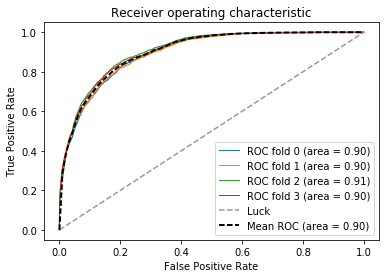

In [8]:
plot_kfold_roc_auc(clf, Xtrain, ytrain, k=4)

Testing AUC: 0.903
             precision    recall  f1-score   support

          0       0.85      0.97      0.90     12435
          1       0.80      0.44      0.57      3846

avg / total       0.84      0.84      0.82     16281



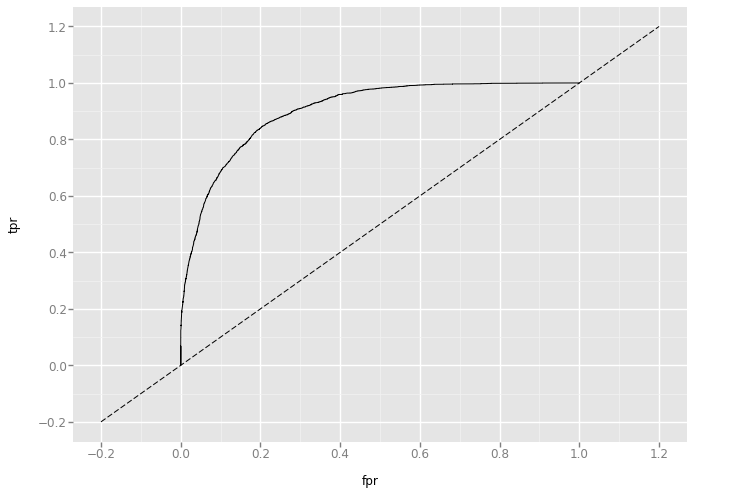

<ggplot: (8734504366885)>


In [9]:
plot_roc_and_metrics(clf, Xtest, ytest)

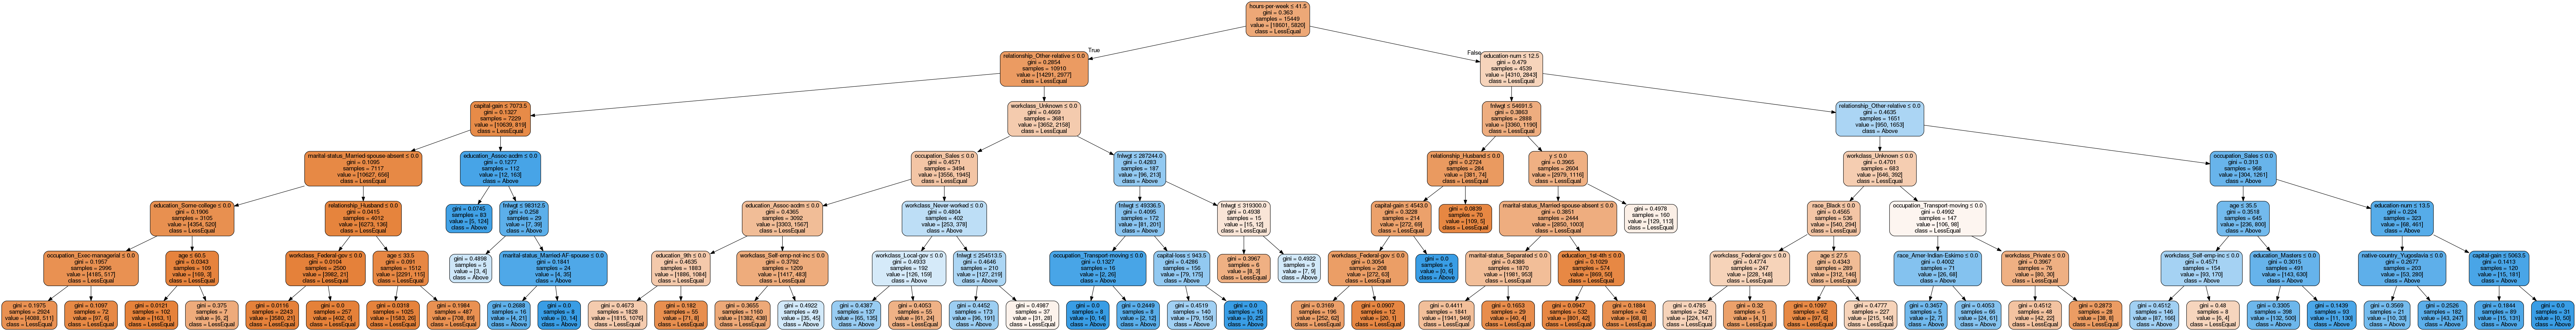

In [10]:
plot_interactive_tree(clf.estimators_[0], train.columns[:-1], class_names=['LessEqual', 'Above'])

In [11]:
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
# Print the feature ranking
print("Feature ranking:")
 
for f in range(Xtrain.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, Xtrain.columns[indices[f]], importances[indices[f]]))


Feature ranking:
1. feature capital-gain (0.146712)
2. feature marital-status_Married-civ-spouse (0.141981)
3. feature relationship_Husband (0.122017)
4. feature education-num (0.103998)
5. feature marital-status_Never-married (0.075729)
6. feature age (0.066669)
7. feature hours-per-week (0.036307)
8. feature relationship_Not-in-family (0.028147)
9. feature occupation_Exec-managerial (0.026864)
10. feature relationship_Own-child (0.026429)
11. feature capital-loss (0.024861)
12. feature occupation_Prof-specialty (0.022586)
13. feature sex_Female (0.020911)
14. feature education_Bachelors (0.019881)
15. feature sex_Male (0.018312)
16. feature education_Masters (0.018190)
17. feature relationship_Wife (0.013551)
18. feature relationship_Unmarried (0.011473)
19. feature education_HS-grad (0.010203)
20. feature occupation_Other-service (0.009699)
21. feature marital-status_Divorced (0.008240)
22. feature education_Prof-school (0.007787)
23. feature workclass_Self-emp-inc (0.006779)
24. fe

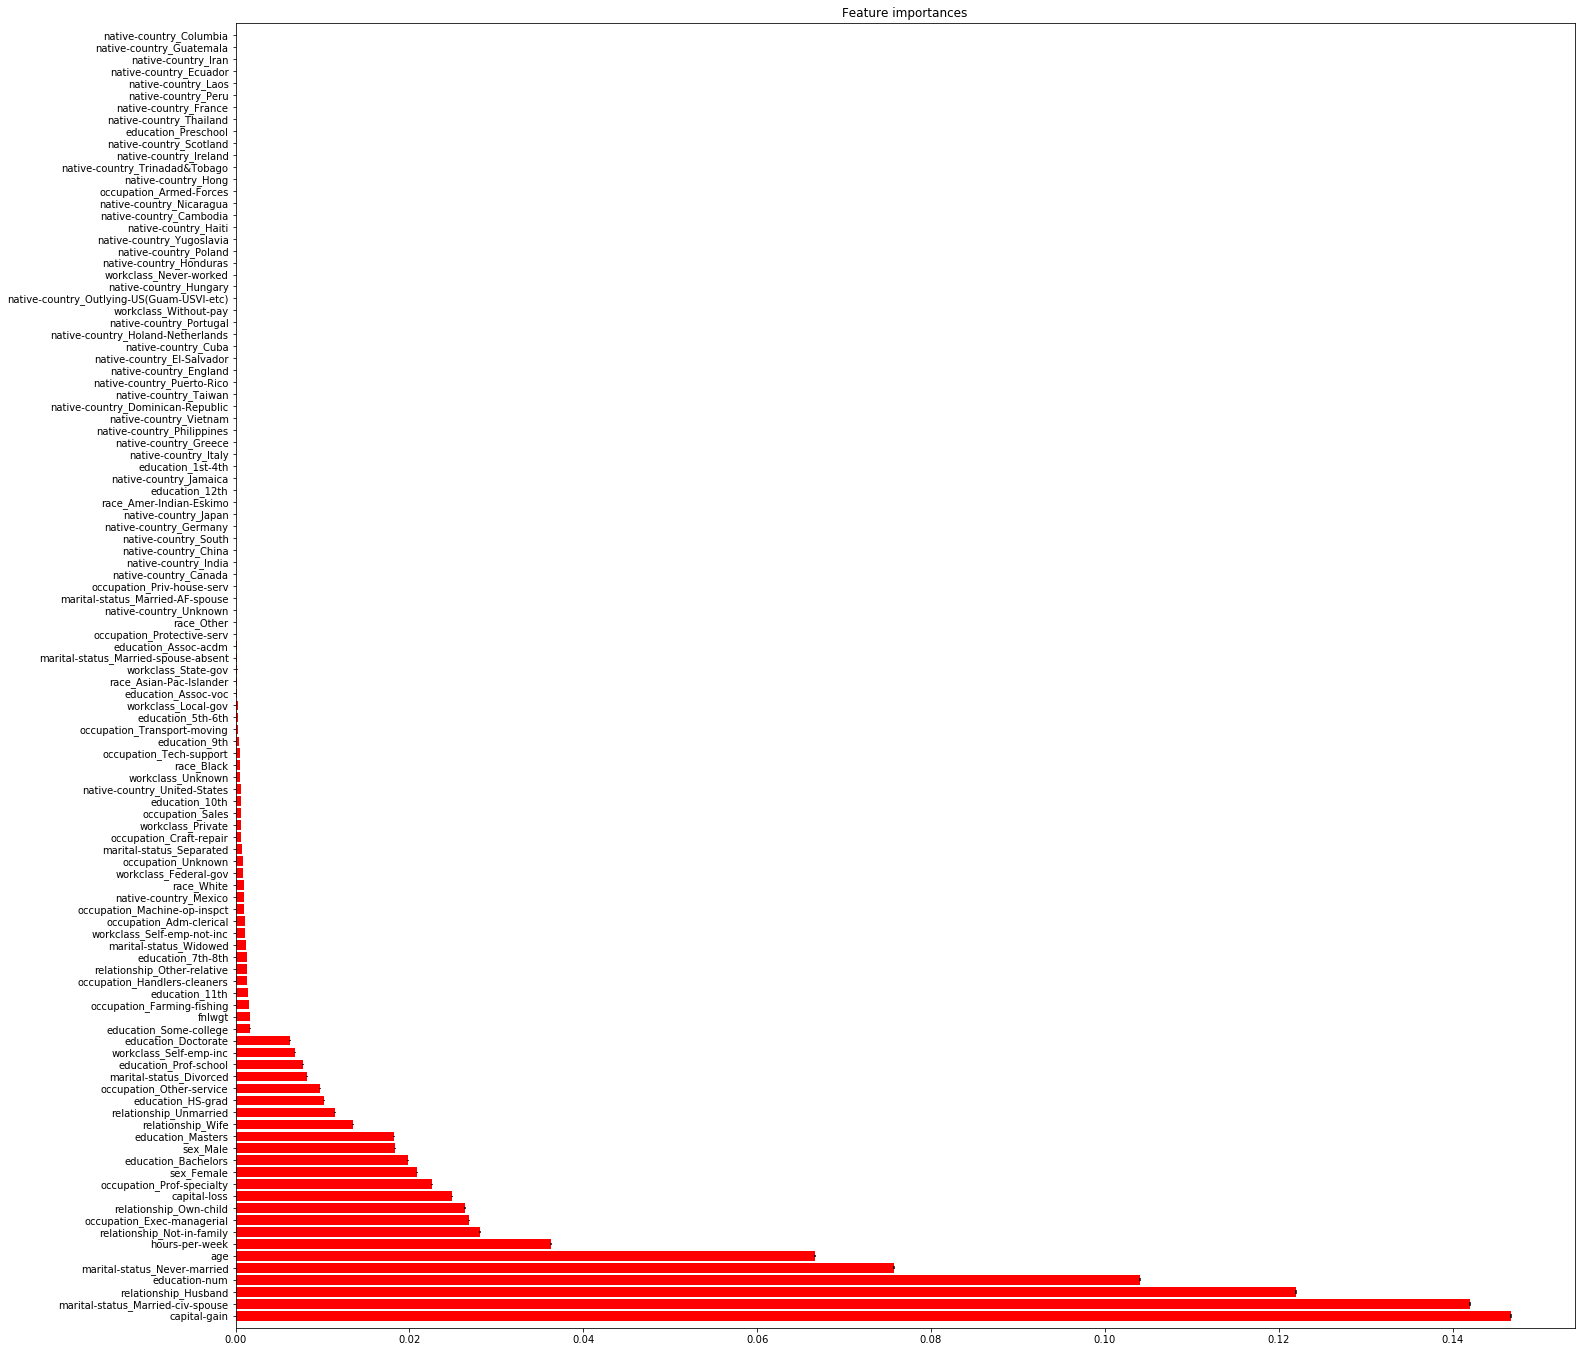

In [12]:

# Plot the feature importances of the forest
feat_important_indeces = [Xtrain.columns[indices[f]] for f in range(Xtrain.shape[1])]
_ = plt.figure(figsize=(24, 24))
_ = plt.title("Feature importances")
_ = plt.barh(range(Xtrain.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
_ = plt.yticks(range(Xtrain.shape[1]), feat_important_indeces)
_ = plt.ylim([-1, Xtrain.shape[1]])

plt.show()

Notes on model performance:

  - Recall from the group that earns above 50k/year was less than 50%, meaning the model has trouble identifying them.
  - Marital status was a big predictor of the earning range

### ANN, Scikit

In [13]:
from sklearn.neural_network import MLPClassifier

nn = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=[64 for _ in range(16)], random_state=1,
                  learning_rate='constant', learning_rate_init=.003, max_iter=int(1e4), activation='relu')

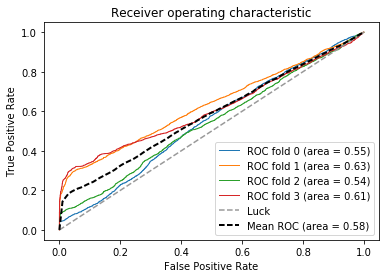

In [14]:
plot_kfold_roc_auc(nn, Xtrain, ytrain, k=4)

Notes:

  - Binary encoding did not work well here. And also, features should have been normalized
  - Different variations of architecture were tested (higher number of layers, neurons per layer), and nothing helped

In [15]:
ftrain = read_data('train')
ftest = read_data('test')
ftrain.head(5)
ftrain.shape

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,y
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


(32561, 15)

In [16]:
N = 48
def hash_fn(x):
    tmp = [0 for _ in range(N)]
    for val in x.values:
        tmp[hash(val) % N] += 1
    return pd.Series(tmp, index=cols)
cols = ['col_%d' % d for d in range(N)]

oXtrain = ftrain.drop(['y'], axis=1)[categorical_features].apply(hash_fn, axis=1)
oXtest = ftest.drop(['y'], axis=1)[categorical_features].apply(hash_fn, axis=1)

# normalize numerical features

for c in ftrain.columns:
    if (c not in categorical_features) and c != 'y':
        oXtrain[c] = ftrain[c]
        oXtest[c] = ftest[c]

for c in oXtrain.columns:
    oXtrain[c] = (oXtrain[c] - oXtrain[c].mean())/(oXtrain[c].max() - oXtrain[c].min() + 1e-8)
    oXtest[c] = (oXtest[c] - oXtest[c].mean())/(oXtest[c].max() - oXtest[c].min() + 1e-8)    

oytrain, oytest = ftrain['y'], ftest['y']


In [17]:
oXtrain.head(5)

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,...,col_44,col_45,col_46,col_47,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
0,0.0,0.0,-0.042689,-0.004207,-0.080342,-0.000031,-0.001536,-0.034228,-0.174902,-0.065661,...,-0.009029,0.0,-0.254824,0.372025,0.005731,-0.076243,0.194621,0.010964,-0.020042,-0.004464
1,0.0,0.0,-0.042689,-0.004207,-0.080342,-0.000031,-0.001536,-0.034228,-0.174902,-0.065661,...,-0.009029,0.0,-0.254824,-0.127975,0.156416,-0.072308,0.194621,-0.010777,-0.020042,-0.279974
2,0.0,0.0,-0.042689,-0.004207,-0.080342,-0.000031,-0.001536,-0.034228,-0.174902,-0.065661,...,-0.009029,0.0,0.078509,0.372025,-0.007968,0.017568,-0.072045,-0.010777,-0.020042,-0.004464
3,0.0,0.0,-0.042689,-0.004207,-0.080342,-0.000031,-0.001536,-0.034228,-0.174902,-0.065661,...,-0.009029,0.0,0.078509,-0.127975,0.197512,0.030523,-0.205379,-0.010777,-0.020042,-0.004464
4,0.0,0.0,-0.042689,-0.004207,-0.080342,-0.000031,-0.001536,0.465772,-0.174902,-0.065661,...,-0.009029,0.0,0.078509,-0.127975,-0.144954,0.100943,0.194621,-0.010777,-0.020042,-0.004464


In [18]:
nn = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=[96 for _ in range(20)], random_state=1,
                  learning_rate='constant', learning_rate_init=.001, max_iter=int(1e4), activation='relu')

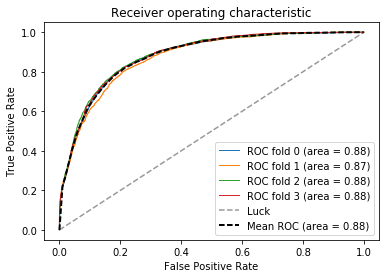

In [19]:
plot_kfold_roc_auc(nn, oXtrain, oytrain, k=4)

Testing AUC: 0.875
             precision    recall  f1-score   support

          0       0.86      0.93      0.90     12435
          1       0.70      0.52      0.60      3846

avg / total       0.83      0.84      0.83     16281



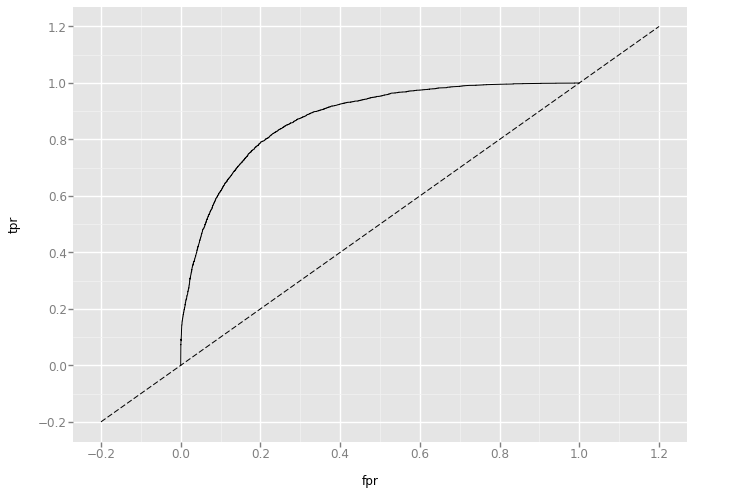

<ggplot: (8734531985385)>


In [20]:
plot_roc_and_metrics(nn, oXtest, oytest)

Notes:

  - With hashing of categorical features, NN performs is much better
  - Normalizing all features (numerical and hashed values) improved results by 1pp
  - Reducing hashing dimension from 64 to 48 did not change results
  - Increasing layers depth from 16 to 20 helped improve performance
  
    

### ANN, NeuPy

In [21]:
# from neupy import algorithms, layers, storage
# from neupy.exceptions import StopTraining

# network = layers.Input(oXtrain.shape[1])

# for size in [96 for _ in range(20)]:
#     network = network > layers.Relu(size) 
#     #network = network > layers.Dropout(proba=.6)

# network = network > layers.Softmax(2)


# def on_epoch_end(gdnet):
#     epoch = gdnet.last_epoch
#     errors = gdnet.validation_errors

#     if errors.previous() and errors.last() > errors.previous():
#         # Load parameters and stop training
#         storage.load(gdnet, '.data/training-epoch-{}.pickle'.format(epoch - 1))
#         raise StopTraining("Training has been interrupted")
#     else:
#         # Save parameters after successful epoch
#         storage.save(gdnet, '.data/training-epoch-{}.pickle'.format(epoch))

# # Valid initialization
# gdnet = algorithms.Adadelta(
#     network,
#     batch_size=200,
#     error='categorical_crossentropy', # binary_crossentropy,
#     verbose=True,
#     shuffle_data=False,
#     show_epoch=10,
#     step=0.001,
#     #epoch_end_signal=on_epoch_end,
# #    addons=[algorithms.WeightDecay,
# #            algorithms.StepDecay]    
# )

# gdnet.architecture()

In [22]:
# gdnet.train(input_train=oXtrain, input_test=oXtest, 
#             target_train=np.stack(np.array([1 - oytrain, oytrain]), axis=1), 
#             target_test=np.stack(np.array([1 - oytest, oytest]), axis=1), 
#             epochs=int(200))

In [23]:
# from neupy import plots
# plots.error_plot(gdnet)

# preds = gdnet.predict(oXtest).round(1)
# preds = np.argmax(preds, axis=1)

# fpr, tpr, _ = metrics.roc_curve(oytest, preds)

# print 'Testing AUC: {:.3f}'.format(metrics.roc_auc_score(oytest, preds))

# print metrics.classification_report(oytest, preds)

# df = pd.DataFrame(dict(fpr=fpr, tpr=tpr))
# ggplot(df, aes(x='fpr', y='tpr')) +\
#     geom_line() +\
#     geom_abline(linetype='dashed')
